In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 15s 1us/step


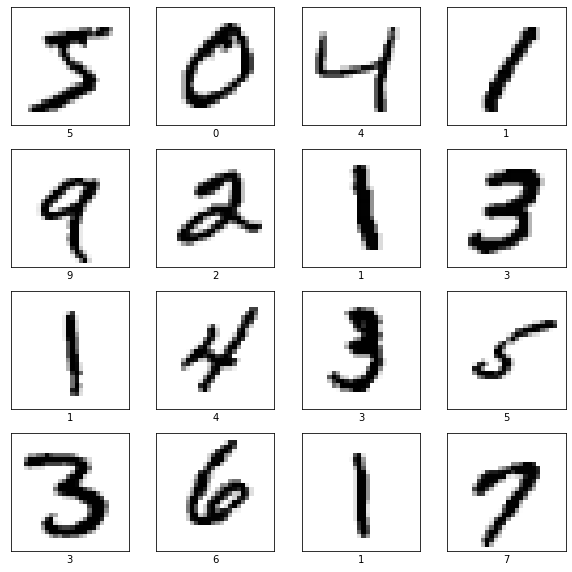

In [4]:
plt.figure(figsize=(10,10))

for i in range(0, 16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train[i], cmap = 'binary')
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [6]:
x_train = np.reshape(x_train, (60000, 28*28))
x_test = np.reshape(x_test, (10000, 28*28))


x_train = x_train / 255.
x_test = x_test / 255.

In [7]:
model = tf.keras.models.Sequential([
     tf.keras.layers.Dense(32, activation='sigmoid', input_shape=(784,)),
     tf.keras.layers.Dense(32, activation='sigmoid'),
     tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [9]:
history = model.fit(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 20, batch_size = 2048,
    verbose = 2    
)

Epoch 1/20
30/30 - 1s - loss: 2.2850 - accuracy: 0.1408 - val_loss: 2.1727 - val_accuracy: 0.4206
Epoch 2/20
30/30 - 1s - loss: 2.0887 - accuracy: 0.5337 - val_loss: 1.9827 - val_accuracy: 0.6200
Epoch 3/20
30/30 - 0s - loss: 1.8865 - accuracy: 0.6625 - val_loss: 1.7642 - val_accuracy: 0.7008
Epoch 4/20
30/30 - 0s - loss: 1.6644 - accuracy: 0.7054 - val_loss: 1.5403 - val_accuracy: 0.7191
Epoch 5/20
30/30 - 1s - loss: 1.4475 - accuracy: 0.7374 - val_loss: 1.3321 - val_accuracy: 0.7675
Epoch 6/20
30/30 - 1s - loss: 1.2513 - accuracy: 0.7794 - val_loss: 1.1494 - val_accuracy: 0.8039
Epoch 7/20
30/30 - 1s - loss: 1.0816 - accuracy: 0.8192 - val_loss: 0.9938 - val_accuracy: 0.8428
Epoch 8/20
30/30 - 0s - loss: 0.9387 - accuracy: 0.8473 - val_loss: 0.8640 - val_accuracy: 0.8633
Epoch 9/20
30/30 - 0s - loss: 0.8202 - accuracy: 0.8639 - val_loss: 0.7576 - val_accuracy: 0.8759
Epoch 10/20
30/30 - 0s - loss: 0.7230 - accuracy: 0.8755 - val_loss: 0.6710 - val_accuracy: 0.8840
Epoch 11/20
30/30 -

<AxesSubplot:>

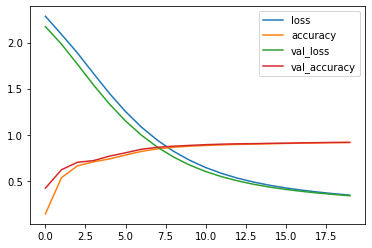

In [16]:
pd.DataFrame(history.history).plot()

In [17]:
model.save('model_simple.h5')

# ML Server

In [23]:
%%writefile ml_server.py

import json
import tensorflow as tf
import numpy as np
import random

from flask import Flask, request

app = Flask(__name__)

model = tf.keras.models.load_model('model_simple.h5')

feature_model = tf.keras.models.Model(
    model.inputs,
    [layer.output for layer in model.layers]    
)

_, (x_test, _) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255.

def get_pred():
    index = np.random.choice(x_test.shape[0])
    image = x_test[index, :, :]
    image_arr = np.reshape(image, (1, 784))
    return feature_model.predict(image_arr), image

@app.route('/', methods = ['GET', 'POST'])
def index():
    if request.method == 'POST':
        pred, image = get_pred()
        final_preds = [p.tolist() for p in pred]
        return json.dumps({
            'predictions': final_preds,
            'image': image.tolist()
        })
    
    return 'Welcome to the server. It sucks but you gonna love it'


if __name__ == '__main__':
    app.run()

Overwriting ml_server.py


Streamlit

In [35]:
%%writefile app.py

import streamlit as st
import json
import requests
import matplotlib.pyplot as plt
import numpy as np

URL = 'http://127.0.0.1:5000'


st.set_option('deprecation.showPyplotGlobalUse', False)
st.title('Neural Network Visualizer')
st.sidebar.markdown('## Input Image')

if st.button('Get random prediction'):
    response = requests.post(URL, data = {})
    response = json.loads(response.text)
    preds = response.get('predictions')
    image = response.get('image')
    image = np.reshape(image, (28,28))
    
    st.sidebar.image(image, width = 150)
    
    
    for layer, p in enumerate(preds):
        numbers = np.squeeze(np.array(p))
        
        plt.figure(figsize = (32, 4))

        if layer == 2:
            row = 1
            col = 10
            
        else:
            row = 2
            col = 16
        
        for i, number in enumerate(numbers):
            plt.subplot(row, col, i +1)
            plt.imshow(number * np.ones((8,8,3)).astype('float32'))
            plt.xticks([])
            plt.yticks([])
            
            if layer == 2:
                plt.xlabel(str(i), fontsize = 40)
                
        plt.subplots_adjust(wspace = 0.05, hspace = 0.05)
        plt.tight_layout()
        st.text('Layer {}'.format(i + 1))
        st.pyplot()

Overwriting app.py
